In [1]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta
from imblearn import under_sampling, over_sampling
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression #LogisticRegression()
from sklearn.neighbors import KNeighborsClassifier
import warnings
from sklearn.decomposition import PCA , FactorAnalysis

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo
import csv
import xgboost
import shap
import statsmodels.api as sm

In [2]:
#read dataset and insert in data frame (df)
df=pd.read_csv('C:\\Users\\AskeR\\projects\\lunar\\bank-marketing.csv')


In [3]:
# changing the col naming to  delimiter-separated naming convension  
df.columns = [x.lower().replace('-', '_').replace(' ', '_') for x in df.columns.to_list()]

df.sample(5, random_state=1)

,age,age_group,eligible,job,salary,marital,education,marital_education,targeted,default,...,contact,day,month,duration,campaign,pdays,previous,poutcome,y,response
3610,42,4,Y,blue-collar,20000,married,primary,married-primary,yes,no,...,unknown,15,may,262,4,-1,0,unknown,no,0
11677,37,3,Y,technician,60000,married,secondary,married-secondary,yes,no,...,unknown,20,jun,167,2,-1,0,unknown,no,0
33018,32,3,Y,admin.,50000,married,secondary,married-secondary,yes,no,...,cellular,17,apr,819,4,-1,0,unknown,no,0
44323,53,5,Y,blue-collar,20000,married,primary,married-primary,yes,no,...,cellular,28,jul,388,3,181,1,success,yes,1
8119,32,3,Y,technician,60000,single,tertiary,single-tertiary,no,no,...,unknown,2,jun,183,5,-1,0,unknown,no,0


In [4]:
# Check For Missing Value (Null, NaN, or None)
#df.isna().sum()

In [5]:
#for x in df.columns.to_list():
#    print(x + ' :')
#    print(df[x].sort_values().unique())
#    print('')

In [6]:
##remove dublicate colums 
non_target_columns = df.columns.to_list()
non_target_columns.remove('y')
non_target_columns.remove('response')

df.duplicated(non_target_columns).sum()

0

In [7]:
#drop y because its redundant with the target column
if 'y' in df.columns.to_list():
  df = df.drop(['y'], axis = 1)

if 'age_group' in df.columns.to_list():
  df = df.drop(['age_group'], axis = 1)


In [8]:
df['age'][1]
#AND df['age'][i] <50

44

In [9]:
#
#i = 1
#while i < 20000:
#    if df['contact'][i] =='telephone':
#        df['response'][i]=0
#    if df['contact'][i] =='cellular':     
#         if df['age'][i] <50 :
#            df['response'][i]=1
#    i += 1
#

In [10]:
#change pdays -1 to 0, see uniqe values earlier
df.pdays = df.pdays.apply(lambda x: 0 if (x == -1) else x)
#df.sample(5, random_state=1)

In [11]:
temp= df.sample(5, random_state=1)
# open the file
f = open('C:\\Users\\AskeR\\projects\\lunar\\out.csv')
#write
temp.to_csv('C:\\Users\\AskeR\\projects\\lunar\\out.csv')

# close the file
f.close()
temp.columns

Index(['age', 'eligible', 'job', 'salary', 'marital', 'education',
       'marital_education', 'targeted', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'response'],
      dtype='object')

In [12]:
#separate column that use categorical and numerical
cats= list(df.select_dtypes(include=['object','datetime64[ns]','bool']) )
nums= list(df.select_dtypes(include='int64') )
print(nums)
print(cats)

['age', 'salary', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'response']
['eligible', 'job', 'marital', 'education', 'marital_education', 'targeted', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


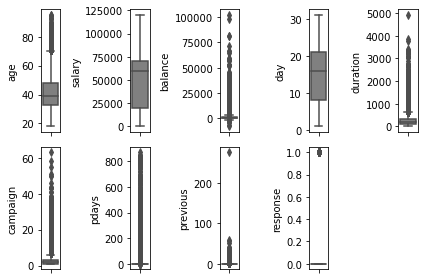

In [13]:
#Detect outlier
for i in range(0, len(nums)):
    plt.subplot(2, (len(nums)/2)+1, i+1)
    sns.boxplot(y=df[nums[i]], color='gray', orient='v')
    plt.tight_layout()

In [14]:
#zscore to take out outlier

from scipy import stats
print(f'Jumlah baris sebelum memfilter outlier: {len(df)}')

filtered_entries = np.array([True] * len(df))

for col in ['balance', 'duration', 'campaign']:
    zscore = abs(stats.zscore(df[col])) # hitung absolute z-scorenya
    filtered_entries = (zscore < 3) & filtered_entries # keep yang kurang dari 3 absolute z-scorenya
    
df = df[filtered_entries] # filter, cuma ambil yang z-scorenya dibawah 3

print(f'Jumlah baris setelah memfilter outlier: {len(df)}')

Jumlah baris sebelum memfilter outlier: 45211
Jumlah baris setelah memfilter outlier: 42707


<AxesSubplot:>

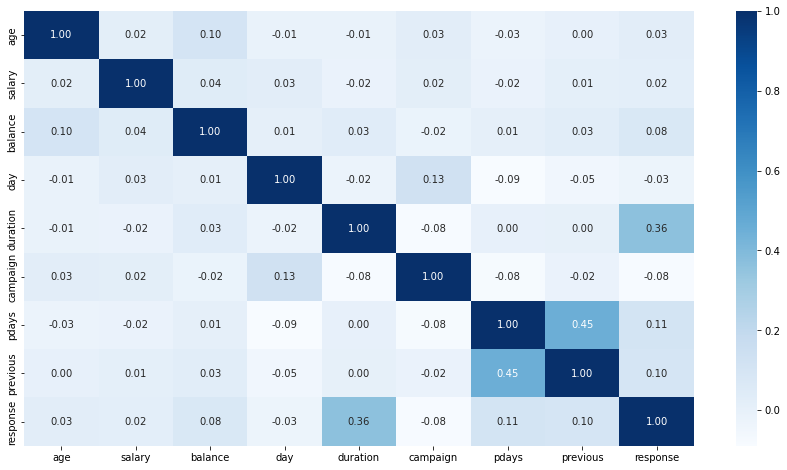

In [15]:
#correlation check
df_new=df.copy()
plt.figure(figsize=(15, 8))
sns.heatmap(df_new.corr(), cmap='Blues', annot=True, fmt='.2f')

<Figure size 1080x1080 with 0 Axes>

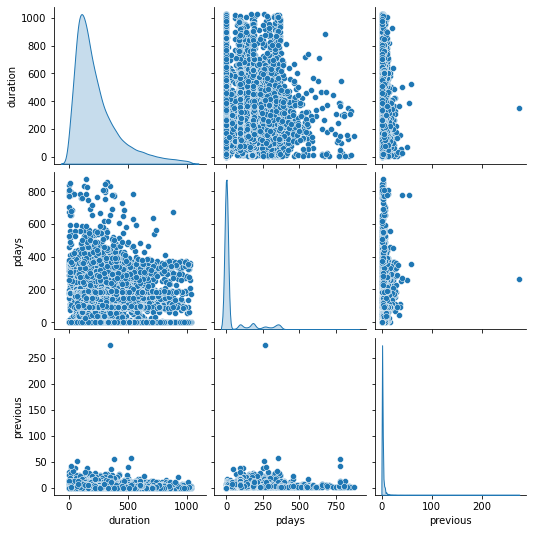

In [16]:
features= ['duration','pdays','previous']
plt.figure(figsize=(15, 15))
sns.pairplot(df_new[features], diag_kind='kde')

Text(0, 0.5, 'count')

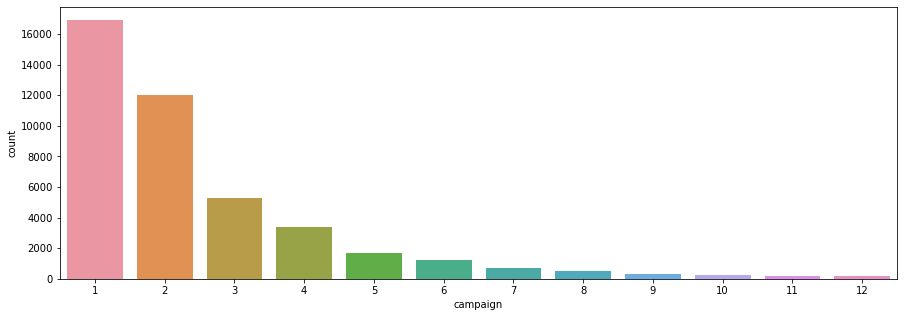

In [17]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(x='campaign', y='age', data=df_new.groupby(['campaign']).agg('count').reset_index()[['campaign', 'age']])
ax.set_ylabel('count')

<Figure size 1080x360 with 0 Axes>

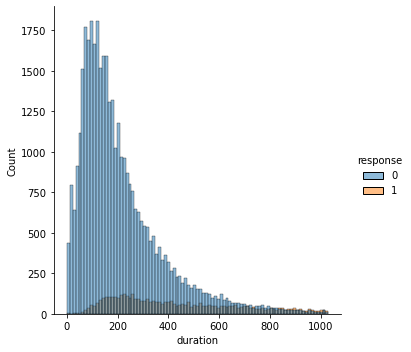

In [18]:
plt.figure(figsize=(15, 5))
sns.displot(x='duration', hue='response', data=df_new)

In [19]:
### Label Encoding
if 'contacted_date' in df_new.columns.to_list():
    df_new.drop(['contacted_date'], axis=1, inplace=True)
if 'pcontacted_date' in df_new.columns.to_list():
    df_new.drop(['pcontacted_date'], axis=1, inplace=True)


for f in df_new.select_dtypes(include='object').columns.to_list():
    df_new[f] = df_new[f].astype('category').cat.codes

    
df.sample(5, random_state=1)    

,age,eligible,job,salary,marital,education,marital_education,targeted,default,balance,...,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response
44065,31,Y,services,70000,single,secondary,single-secondary,yes,no,1027,...,no,cellular,2,jul,217,3,0,0,unknown,1
4030,57,Y,retired,55000,married,primary,married-primary,yes,no,70,...,yes,unknown,16,may,186,5,0,0,unknown,0
16077,51,Y,blue-collar,20000,married,secondary,married-secondary,yes,no,0,...,yes,cellular,22,jul,124,2,0,0,unknown,0
20908,50,Y,services,70000,married,primary,married-primary,yes,no,12,...,no,cellular,13,aug,168,1,0,0,unknown,0
218,46,Y,housemaid,16000,married,primary,married-primary,yes,no,965,...,no,unknown,5,may,177,1,0,0,unknown,0


In [20]:
df_new.sample(5, random_state=1)

,age,eligible,job,salary,marital,education,marital_education,targeted,default,balance,...,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response
44065,31,1,7,70000,2,1,9,1,0,1027,...,0,0,2,5,217,3,0,0,3,1
4030,57,1,5,55000,1,0,4,1,0,70,...,1,2,16,8,186,5,0,0,3,0
16077,51,1,1,20000,1,1,5,1,0,0,...,1,0,22,5,124,2,0,0,3,0
20908,50,1,7,70000,1,0,4,1,0,12,...,0,0,13,1,168,1,0,0,3,0
218,46,1,3,16000,1,0,4,1,0,965,...,0,2,5,8,177,1,0,0,3,0


<AxesSubplot:>

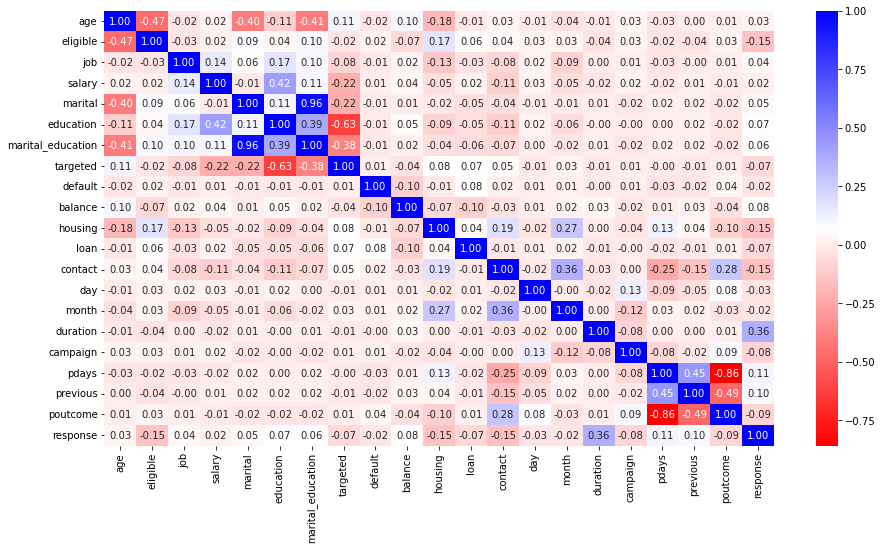

In [21]:
#correlation check
plt.figure(figsize=(15, 8))
sns.heatmap(df_new.corr(), cmap='bwr_r', annot=True, fmt='.2f')

<AxesSubplot:xlabel='response', ylabel='count'>

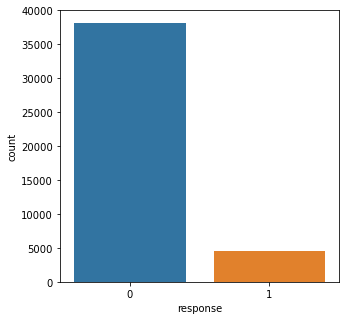

In [22]:
#check imbalance
df_new['response'].value_counts()
plt.figure(figsize=(5, 5))
sns.countplot(x ='response', data = df_new)

In [23]:
x = df_new.drop(['response'], axis=1)
y = df_new[['response']]


In [24]:
#do smote to balancing our target column
x_over, y_over = over_sampling.SMOTE(0.5).fit_resample(x, y)
print((y_over).value_counts())

response
0           38125
1           19062
dtype: int64


In [25]:

x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size = 0.3, random_state = 42)

In [26]:
#x_train.columns

In [41]:
def eval_classification(model, pred, xtrain, ytrain, xtest, ytest):
    print("\nAccuracy (Test Set): %.2f" % accuracy_score(ytest, pred))
    print("Precision (Test Set): %.2f" % precision_score(ytest, pred))
    print("Recall (Test Set): %.2f" % recall_score(ytest, pred))
    print("F1-Score (Test Set): %.2f" % f1_score(ytest, pred))
    
    fpr, tpr, thresholds = roc_curve(ytest, pred, pos_label=1) # pos_label: label yang kita anggap positive
    print("AUC: %.2f" % auc(fpr, tpr))

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model, hyperparameters):
    for key, value in hyperparameters.items() :
        print('Best '+key+':', model.get_params()[key])
        
        
        
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')



Accuracy (Test Set): 0.88
Precision (Test Set): 0.81
Recall (Test Set): 0.83
F1-Score (Test Set): 0.82
AUC: 0.86
[0.05183024 0.0159088  0.0215354  0.01690808 0.00601283 0.01566358
 0.02514383 0.01326546 0.00078078 0.0676893  0.12621461 0.02707347
 0.05219143 0.05827875 0.07043675 0.30652854 0.03047183 0.02184998
 0.00890884 0.06330748]


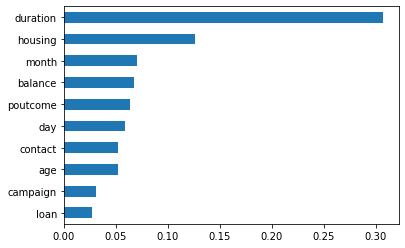

In [28]:
#model Decision Tree
model = DecisionTreeClassifier(random_state=42)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
eval_classification(model, y_pred, x_train, y_train, x_test, y_test)
print(model.feature_importances_)

feat_importances = pd.Series(model.feature_importances_, index=x.columns)
# feat_importances = feat_importances.sort_values(ascending=True)
ax = feat_importances.nlargest(10).plot(kind='barh')
ax.invert_yaxis()


In [29]:
#logistic regression

model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
eval_classification(model, y_pred, x_train, y_train, x_test, y_test)


Accuracy (Test Set): 0.76
Precision (Test Set): 0.69
Recall (Test Set): 0.50
F1-Score (Test Set): 0.58
AUC: 0.69


In [30]:
    x1 = x.drop(['loan'], axis = 1)
    x1 = x1.drop(['day'], axis = 1)
    x1 = x1.drop(['month'], axis = 1)
    x1 = x1.drop(['marital_education'], axis = 1)
    y1 = y
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y, random_state=0)

logreg = LogisticRegression().fit(x1_train,y1_train)
logreg

print("Training set score: {:.3f}".format(logreg.score(x1_train,y1_train)))
print("Test set score: {:.3f}".format(logreg.score(x1_test,y1_test)))

logit_model=sm.Logit(y,x1)
result=logit_model.fit()
print(result.summary())

Training set score: 0.891
Test set score: 0.893
Optimization terminated successfully.
         Current function value: 0.248215
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:               response   No. Observations:                42707
Model:                          Logit   Df Residuals:                    42691
Method:                           MLE   Df Model:                           15
Date:                Wed, 16 Feb 2022   Pseudo R-squ.:                  0.2717
Time:                        20:22:37   Log-Likelihood:                -10601.
converged:                       True   LL-Null:                       -14555.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.0272      0.001    -18.181      0.000      


Accuracy (Test Set): 0.92
Precision (Test Set): 0.89
Recall (Test Set): 0.87
F1-Score (Test Set): 0.88
AUC: 0.91
[0.05121447 0.02948749 0.0273071  0.02651287 0.02597654 0.03707221
 0.03956682 0.0331486  0.00202755 0.05127494 0.09863206 0.02964955
 0.06340523 0.05445694 0.0649433  0.20920767 0.04264903 0.02836357
 0.01707157 0.06803247]


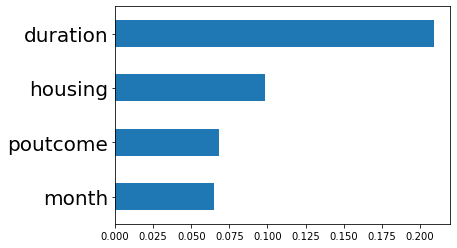

In [31]:
#extra tree classifier
model = ExtraTreesClassifier(random_state=42)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
eval_classification(model, y_pred, x_train, y_train, x_test, y_test)
print(model.feature_importances_)

feat_importances = pd.Series(model.feature_importances_, index=x.columns)
# plt.figure(figsize=(12, 12))
plt.rcParams['ytick.labelsize'] = '20'
ax = feat_importances.nlargest(4).plot(kind='barh')
ax.invert_yaxis()
plt.show()

In [32]:
#knn
model = KNeighborsClassifier(n_neighbors=5)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
eval_classification(model, y_pred, x_train, y_train, x_test, y_test)


Accuracy (Test Set): 0.84
Precision (Test Set): 0.73
Recall (Test Set): 0.82
F1-Score (Test Set): 0.77
AUC: 0.83


In [33]:
#decision tree
model = DecisionTreeClassifier(random_state=42)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
eval_classification(model, y_pred, x_train, y_train, x_test, y_test)


Accuracy (Test Set): 0.88
Precision (Test Set): 0.81
Recall (Test Set): 0.83
F1-Score (Test Set): 0.82
AUC: 0.86


[20:22:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Accuracy (Test Set): 0.93
Precision (Test Set): 0.89
Recall (Test Set): 0.89
F1-Score (Test Set): 0.89
AUC: 0.92


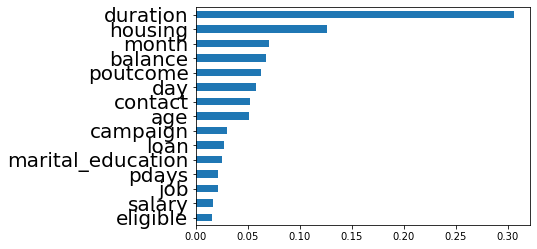

In [34]:
#xg boost
warnings.filterwarnings("ignore", module="XGBoost")

xg = XGBClassifier(random_state=42,n_estimators=1000)
xg.fit(x_train, y_train)

y_pred = xg.predict(x_test)

eval_classification(xg, y_pred, x_train, y_train, x_test, y_test)

feat_importances = pd.Series(model.feature_importances_, index=x.columns)
# plt.figure(figsize=(12, 12))
plt.rcParams['ytick.labelsize'] = '20'
ax = feat_importances.nlargest(15).plot(kind='barh')
ax.invert_yaxis()
plt.show()


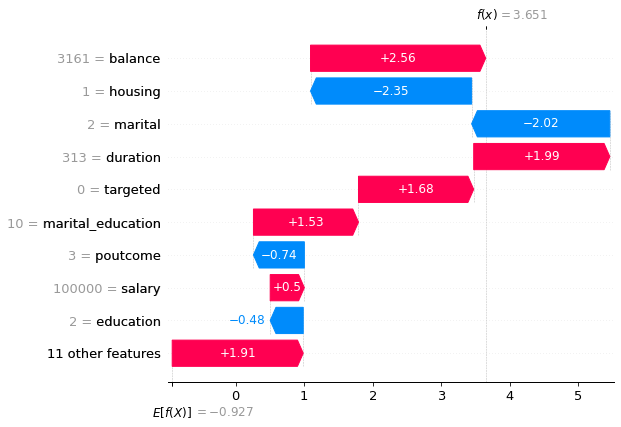

marital = 2 = single


In [38]:

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)

explainer = shap.Explainer(xg)
shap_values = explainer(x_train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])
print("marital = 2 = single")

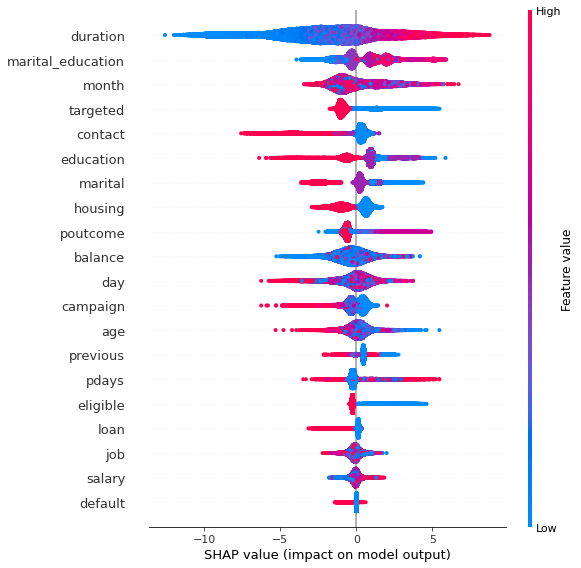

In [49]:
shap.summary_plot(shap_values, x_train)

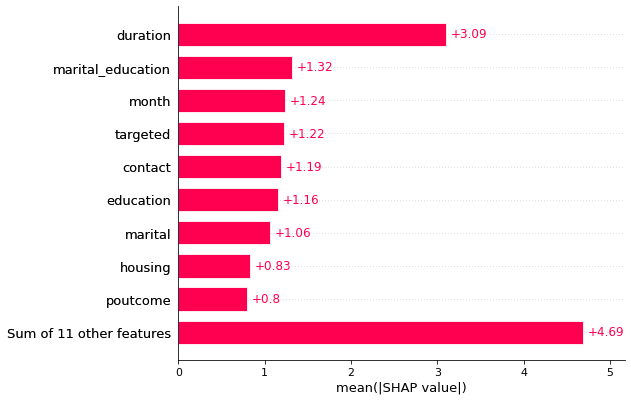

In [39]:
shap.plots.bar(shap_values)

In [47]:
type(x_train)

pandas.core.frame.DataFrame

In [46]:
 def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values,x_train) 



ValueError: DataFrame constructor not properly called!

In [ ]:
# scalar for PCA and factor
scaler= StandardScaler()
scaler.fit(x_train)
x_scaled = scaler.transform(x_train)

In [ ]:
pca = PCA(n_components=10)
pca.fit(x_scaled)
#print(f"PCA components: \n {pca.components_}")

In [ ]:
plt.matshow(pca.components_,cmap='bwr_r')
plt.yticks([0,1,2,3,4,5,6,7,8,9],["1","2","3","4","5","6","7","8","9","10"])
plt.colorbar()
plt.xticks(
    range(len(x_train.columns)),
    x_train.columns, rotation= 60 , ha='left')

In [ ]:
#fa = FactorAnalysis(rotation="varimax",n_components=10)
#fa.fit(x_scaled)
#FactorAnalysis.score


#from factor_analyzer import FactorAnalyzer
fa = FactorAnalyzer()
#fa.analyze(x_scaled, 25, rotation="varimax")
fa.analyze(x_scaled)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()


#FactorAnalysis(rotation="varimax")

plt.matshow(fa.components_,cmap='bwr_r')
plt.yticks([0,1,2,3,4,5,6,7,8,9],["1","2","3","4","5","6","7","8","9","10"])
plt.colorbar()
plt.xticks(
    range(len(x_train.columns)),
    x_train.columns, rotation= 60 , ha='left')




In [ ]:
v = fa.get_eigenvalues()



In [ ]:

x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size = 0.3, random_state = 42)

x_scaled.delete()

In [ ]:
kmo_all,kmo_model=calculate_kmo(x_scaled)
kmo_model

In [ ]:
x2 = df_new.drop(['response'], axis=1)
x2 = x2.drop(['age_group'], axis=1)
y2 = df_new[['response']]

x_over2, y_over2 = over_sampling.SMOTE(0.5).fit_resample(x2, y2)
x_train2, x_test2, y_train2, y_test2 = train_test_split(x_over2, y_over2, test_size = 0.3, random_state = 42)

scaler= StandardScaler()
scaler.fit(x_train2)
x_scaled2 = scaler.transform(x_train2)

kmo_all2,kmo_model2=calculate_kmo(x_scaled2)
kmo_model2